## 0. Configuración del Entorno

Este notebook implementa un chatbot médico que utiliza un modelo de lenguaje (LLM) de OpenAI para procesar preguntas en lenguaje natural sobre una base de datos médica y generar consultas SQL relevantes.

In [20]:
# Configuración del entorno y claves API
import os
from dotenv import load_dotenv

# Intentar cargar variables de entorno desde un archivo .env si existe
try:
    load_dotenv()
except:
    pass

# Configuración de la API de Deepseek (preferiblemente desde variables de entorno)
LLM_API_KEY = os.environ.get("DEEPSEEK_API_KEY", "sk-aedf531ee17447aa95c9102e595f29ae")
LLM_API_URL = os.environ.get("DEEPSEEK_API_URL", "https://api.deepseek.com/v1/chat/completions")
LLM_MODEL = os.environ.get("DEEPSEEK_MODEL", "deepseek-chat")  # Corregido el nombre del modelo
LLM_PROVIDER = "deepseek"  # Identificador del proveedor de LLM

# Verificar configuración
if not LLM_API_KEY:
    print("⚠️ Advertencia: No se ha configurado LLM_API_KEY. El chatbot funcionará en modo fallback.")
else:
    print(f"✅ Configuración de {LLM_PROVIDER} cargada correctamente")
    
# Mostrar la configuración actual (ocultando la clave completa por seguridad)
if LLM_API_KEY:
    masked_key = LLM_API_KEY[:8] + "..." + LLM_API_KEY[-4:]
    print(f"API Key: {masked_key}")
print(f"API URL: {LLM_API_URL}")
print(f"Modelo: {LLM_MODEL}")
print(f"Proveedor: {LLM_PROVIDER}")

# Configuración de fallback (por si la API de LLM no está disponible)
USE_LLM = True  # Cambiar a False para desactivar el uso de LLM y usar solo el procesamiento basado en reglas

✅ Configuración de deepseek cargada correctamente
API Key: sk-aedf5...29ae
API URL: https://api.deepseek.com/v1/chat/completions
Modelo: deepseek-chat
Proveedor: deepseek


# Chatbot para Base de Datos Médica

Este notebook implementa un chatbot capaz de consultar la base de datos médica y responder preguntas en lenguaje natural sobre:
- Información de pacientes
- Citas médicas y historial de atención
- Datos oncológicos y diagnósticos
- Estadísticas y tendencias médicas

El chatbot convertirá preguntas en lenguaje natural a consultas SQL, ejecutará estas consultas en la base de datos, y presentará los resultados de manera comprensible.

In [21]:
# Importar bibliotecas necesarias
import sqlite3
import os
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import warnings
import json
import requests
from typing import Dict, List, Any, Tuple, Optional
warnings.filterwarnings('ignore')

# Descargar recursos de NLTK si es necesario
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Configurar visualización
%matplotlib inline
plt.style.use('ggplot')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

## 1. Conexión a la Base de Datos

Primero, estableceremos la conexión con la base de datos y cargaremos información sobre su estructura.

In [29]:
# Establecer conexión a la base de datos
def connect_to_database():
    # Buscar la base de datos en el directorio actual y subdirectorios
    import glob
    
    # Ruta conocida desde el análisis previo
    db_path = "db/database.sqlite3.db"
    
    # Si no existe en la ruta conocida, buscar en el sistema de archivos
    if not os.path.isfile(db_path):
        sqlite_files = glob.glob("**/*.db", recursive=True) + glob.glob("**/*.sqlite3", recursive=True)
        if sqlite_files:
            db_path = sqlite_files[0]
    
    print(f"Conectando a la base de datos: {db_path}")
    
    try:
        conn = sqlite3.connect(db_path)
        print("Conexión establecida correctamente")
        return conn
    except sqlite3.Error as e:
        print(f"Error al conectar a la base de datos: {e}")
        return None

# Cargar metadata de la base de datos
def load_database_metadata(conn):
    # Obtener todas las tablas
    cursor = conn.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = [table[0] for table in cursor.fetchall()]
    
    # Diccionario para almacenar la estructura de cada tabla
    db_structure = {}
    
    for table in tables:
        cursor.execute(f"PRAGMA table_info({table})")
        columns = cursor.fetchall()
        db_structure[table] = {
            'columns': [col[1] for col in columns],
            'types': [col[2] for col in columns],
            'primary_key': [col[1] for col in columns if col[5] == 1]
        }
    
    return db_structure

# Conectar a la base de datos y cargar la metadata
conn = connect_to_database()
if conn:
    db_structure = load_database_metadata(conn)
    
    # Mostrar información sobre las categorías principales
    categories = {}
    for table in db_structure.keys():
        prefix = table.split('_')[0] if '_' in table else 'OTHER'
        if prefix not in categories:
            categories[prefix] = []
        categories[prefix].append(table)
    
    # Creamos un cursor para contar filas
    cursor = conn.cursor()
    print("\nCategorías de tablas en la base de datos:")
    for category, tables in sorted(categories.items(), key=lambda x: len(x[1]), reverse=True)[:10]:
        table_count = len(tables)
        total_rows = 0
        total_columns = 0
        for table in tables:
            cursor.execute(f"SELECT COUNT(*) FROM {table}")
            total_rows += cursor.fetchone()[0]
            total_columns += len(db_structure[table]['columns'])
        print(f"{category}: {table_count} tablas, {total_rows} filas, {total_columns} columnas")
    # Mostrar también el total de tablas en la base de datos
    print(f"Total de tablas en la base de datos: {len(db_structure)}")

Conectando a la base de datos: db/database.sqlite3.db
Conexión establecida correctamente

Categorías de tablas en la base de datos:
ONCO: 35 tablas, 2109 filas, 196 columnas
APPO: 26 tablas, 23503 filas, 163 columnas
APPR: 15 tablas, 60 filas, 72 columnas
CURE: 14 tablas, 47 filas, 57 columnas
EPIS: 14 tablas, 7963 filas, 96 columnas
HIST: 14 tablas, 723 filas, 108 columnas
PATI: 12 tablas, 3106 filas, 103 columnas
ALLE: 9 tablas, 40 filas, 40 columnas
MEDI: 7 tablas, 48954 filas, 39 columnas
PARA: 7 tablas, 540 filas, 33 columnas
Total de tablas en la base de datos: 236


## 2. Preprocesamiento de Preguntas

Desarrollaremos funciones para procesar preguntas en lenguaje natural, identificando palabras clave y entidades relevantes.

In [23]:
# Sistema de procesamiento de preguntas basado en LLM de Deepseek
def process_question_with_llm(question: str, db_structure: Dict) -> Dict:
    """
    Procesa una pregunta en lenguaje natural utilizando Deepseek para extraer palabras clave
    y entender la intención del usuario.
    
    Args:
        question: La pregunta del usuario en lenguaje natural
        db_structure: Estructura de la base de datos para proporcionar contexto al modelo
        
    Returns:
        Un diccionario con la información estructurada extraída de la pregunta
    """
    # Crear un resumen de la estructura de la base de datos para el contexto
    db_summary = create_database_summary(db_structure)
    
    # Preparar el mensaje para la API de LLM
    system_message = f"""
    Eres un asistente especializado en análisis de bases de datos médicas. Tu tarea es analizar 
    preguntas en lenguaje natural y extraer información estructurada que se pueda utilizar para 
    generar consultas SQL.

    La base de datos tiene las siguientes tablas principales:
    {db_summary}

    Analiza la pregunta del usuario y proporciona la siguiente información en formato JSON:
    - tables: Lista de tablas relevantes para la consulta
    - actions: Tipo de acción requerida (SELECT, COUNT, AVG, MAX, MIN, SUM)
    - columns: Columnas específicas mencionadas o relevantes
    - conditions: Condiciones que deben aplicarse (por ejemplo, filtros)
    - values: Valores específicos mencionados para condiciones
    
    Responde solo con el JSON, sin texto adicional.
    """
    
    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": question}
    ]
    
    try:
        response = call_llm_api(messages)
        structured_info = extract_structured_info(response)
        return structured_info
    except Exception as e:
        print(f"Error al procesar la pregunta con el LLM: {e}")
        # Fallback a un análisis básico en caso de error
        return {
            'tables': ['PATI_PATIENTS'],  # Tabla por defecto
            'actions': ['SELECT'],
            'columns': [],
            'conditions': [],
            'values': []
        }

def create_database_summary(db_structure: Dict) -> str:
    """
    Crea un resumen conciso de la estructura de la base de datos para proporcionar contexto al LLM.
    """
    # Identificar tablas principales por prefijo
    main_prefixes = ['PATI', 'APPO', 'ONCO', 'EPIS', 'MEDI', 'HIST']
    
    summary_lines = []
    
    # Crear un resumen de las tablas principales y sus columnas más importantes
    for prefix in main_prefixes:
        relevant_tables = [t for t in db_structure.keys() if t.startswith(f"{prefix}_") and '_TYPES' not in t]
        
        for table in relevant_tables[:3]:  # Limitar a 3 tablas por prefijo para no sobrecargar el contexto
            if table in db_structure:
                # Extraer columnas clave (ID, fechas, nombres, descripciones)
                key_columns = [col for col in db_structure[table]['columns'] 
                           if '_ID' in col or 'DATE' in col or 'NAME' in col or 'DESCRIPTION' in col]
                
                # Limitar la cantidad de columnas en el resumen
                if len(key_columns) > 5:
                    key_columns = key_columns[:5]
                
                summary_lines.append(f"- {table}: {', '.join(key_columns)}")
    
    return "\n".join(summary_lines)

def call_llm_api(messages: List[Dict]) -> str:
    """
    Llama a la API de LLM (Deepseek) para procesar los mensajes.
    
    Args:
        messages: Lista de mensajes para la conversación con el modelo
        
    Returns:
        La respuesta generada por el modelo
    """
    headers = {
        "Authorization": f"Bearer {LLM_API_KEY}",
        "Content-Type": "application/json"
    }
    
    # Configuración de la solicitud basada en el proveedor
    if LLM_PROVIDER == "deepseek":
        payload = {
            "model": LLM_MODEL,
            "messages": messages,
            "temperature": 0.1,  # Baja temperatura para respuestas más precisas y deterministas
            "max_tokens": 500    # Limitar la longitud de la respuesta
        }
    else:
        # Configuración genérica similar a OpenAI
        payload = {
            "model": LLM_MODEL,
            "messages": messages,
            "temperature": 0.1
        }
    
    try:
        response = requests.post(LLM_API_URL, headers=headers, json=payload)
        response.raise_for_status()  # Raise exception for HTTP errors
        
        result = response.json()
        
        # Extraer el contenido según el proveedor del LLM
        if LLM_PROVIDER == "deepseek":
            if "choices" in result and len(result["choices"]) > 0:
                return result["choices"][0]["message"]["content"]
        else:
            # Formato genérico similar a OpenAI
            if "choices" in result and len(result["choices"]) > 0:
                return result["choices"][0]["message"]["content"]
            
        raise ValueError("No se pudo extraer contenido de la respuesta del LLM")
    
    except requests.exceptions.RequestException as e:
        print(f"Error en la solicitud al LLM: {e}")
        if hasattr(e, 'response') and e.response is not None:
            print(f"Respuesta de error: {e.response.text}")
        raise

def extract_structured_info(response: str) -> Dict:
    """
    Extrae información estructurada del texto de respuesta generado por el LLM.
    
    Args:
        response: La respuesta en texto generada por el modelo
        
    Returns:
        Un diccionario con la información estructurada
    """
    # Inicializamos con valores por defecto
    structured_info = {
        'tables': [],
        'actions': [],
        'columns': [],
        'conditions': [],
        'values': []
    }
    
    try:
        # Intentar analizar la respuesta como JSON
        # Primero, extraer solo la parte JSON si hay texto adicional
        json_match = re.search(r'(\{.*\})', response, re.DOTALL)
        if json_match:
            json_str = json_match.group(1)
            parsed_response = json.loads(json_str)
        else:
            parsed_response = json.loads(response)
        
        # Actualizar el diccionario con los valores del JSON
        for key in structured_info.keys():
            if key in parsed_response and isinstance(parsed_response[key], list):
                structured_info[key] = parsed_response[key]
        
    except (json.JSONDecodeError, ValueError) as e:
        print(f"Error al analizar la respuesta JSON: {e}")
        print(f"Respuesta recibida: {response}")
        
        # Extraer información mediante expresiones regulares como fallback
        table_match = re.search(r'tables?["\s:]+\[(.*?)\]', response, re.IGNORECASE | re.DOTALL)
        if table_match:
            tables = re.findall(r'"(.*?)"', table_match.group(1))
            structured_info['tables'] = tables
        
        action_match = re.search(r'actions?["\s:]+\[(.*?)\]', response, re.IGNORECASE | re.DOTALL)
        if action_match:
            actions = re.findall(r'"(.*?)"', action_match.group(1))
            structured_info['actions'] = actions
    
    # Si no se encontró ninguna tabla, usar PATI_PATIENTS como predeterminada
    if not structured_info['tables']:
        structured_info['tables'].append('PATI_PATIENTS')
    
    # Si no se encontró ninguna acción, usar SELECT como predeterminada
    if not structured_info['actions']:
        structured_info['actions'].append('SELECT')
    
    return structured_info

# Ejemplo de uso para demostrar la funcionalidad
example_question = "Muestra los pacientes con cáncer mayores de 50 años"
print("Analizando la pregunta con el modelo LLM...")
extracted_info = process_question_with_llm(example_question, db_structure)
print(f"Información estructurada extraída: {json.dumps(extracted_info, indent=2)}")

Analizando la pregunta con el modelo LLM...
Información estructurada extraída: {
  "tables": [
    "PATI_PATIENTS",
    "ONCO_CANCERS"
  ],
  "actions": [
    "SELECT"
  ],
  "columns": [
    "PATI_ID",
    "PATI_NAME",
    "PATI_SURNAME_1",
    "PATI_SURNAME_2",
    "PATI_CLINICAL_HISTORY_ID"
  ],
  "conditions": [
    "PATI_PATIENTS.PATI_ID = ONCO_CANCERS.PATI_ID",
    "PATI_PATIENTS.PATI_AGE > 50"
  ],
  "values": []
}
Información estructurada extraída: {
  "tables": [
    "PATI_PATIENTS",
    "ONCO_CANCERS"
  ],
  "actions": [
    "SELECT"
  ],
  "columns": [
    "PATI_ID",
    "PATI_NAME",
    "PATI_SURNAME_1",
    "PATI_SURNAME_2",
    "PATI_CLINICAL_HISTORY_ID"
  ],
  "conditions": [
    "PATI_PATIENTS.PATI_ID = ONCO_CANCERS.PATI_ID",
    "PATI_PATIENTS.PATI_AGE > 50"
  ],
  "values": []
}


## 3. Generación de Consultas SQL

Implementaremos un sistema para convertir las palabras clave extraídas en consultas SQL válidas.

In [30]:
# Generación de consultas SQL basadas en la información extraída por el LLM
def generate_sql_query(keywords: Dict, db_structure: Dict) -> str:
    """
    Genera una consulta SQL basada en la información estructurada extraída de la pregunta.
    
    Args:
        keywords: Diccionario con información estructurada de la pregunta
        db_structure: Estructura de la base de datos
        
    Returns:
        Consulta SQL generada
    """
    # Determinar la acción a realizar
    action = 'SELECT'
    if keywords['actions']:
        possible_actions = ['SELECT', 'COUNT', 'AVG', 'MAX', 'MIN', 'SUM']
        for a in keywords['actions']:
            if a.upper() in possible_actions:
                action = a.upper()
                break
    
    # Determinar las tablas principales
    if keywords['tables']:
        main_table = keywords['tables'][0]
    else:
        # Si no se especifica una tabla, usar PATI_PATIENTS como predeterminada
        main_table = 'PATI_PATIENTS'
        
    # Verificar si la tabla existe, si no usar una tabla existente que se aproxime
    if main_table not in db_structure:
        # Encontrar una tabla que contenga el nombre de la tabla solicitada
        matching_tables = [t for t in db_structure.keys() if main_table.lower() in t.lower()]
        if matching_tables:
            main_table = matching_tables[0]
        else:
            # Si no hay coincidencia, usar PATI_PATIENTS como predeterminada
            main_table = 'PATI_PATIENTS'
    
    # Determinar columnas específicas a seleccionar
    selected_columns = '*'  # Por defecto, seleccionar todas las columnas
    if keywords['columns'] and len(keywords['columns']) > 0:
        # Filtrar columnas que realmente existen en la tabla
        if main_table in db_structure:
            valid_columns = [col for col in keywords['columns'] if col in db_structure[main_table]['columns']]
            if valid_columns:
                selected_columns = ', '.join(valid_columns)
    
    # Construir la consulta SQL según el tipo de acción
    if action == 'SELECT':
        sql = f"SELECT {selected_columns} FROM {main_table}"
    elif action == 'COUNT':
        sql = f"SELECT COUNT(*) as COUNT_TOTAL FROM {main_table}"
    else:  # AVG, MAX, MIN, SUM
        # Estas funciones de agregación necesitan una columna numérica específica
        if keywords['columns']:
            col = keywords['columns'][0]
            # Verificar si la columna existe en la tabla
            if main_table in db_structure and col in db_structure[main_table]['columns']:
                sql = f"SELECT {action}({col}) as {action}_VALUE FROM {main_table}"
            else:
                # Si la columna no existe, buscar una columna numérica adecuada
                numeric_col = find_numeric_column(db_structure, main_table)
                if numeric_col:
                    sql = f"SELECT {action}({numeric_col}) as {action}_VALUE FROM {main_table}"
                else:
                    # Si no hay columnas numéricas, usar COUNT como alternativa
                    sql = f"SELECT COUNT(*) as COUNT_TOTAL FROM {main_table}"
                    print(f"Advertencia: No se pudo encontrar una columna adecuada para {action}, usando COUNT en su lugar.")
        else:
            # Si no se especificó una columna, buscar una columna numérica adecuada
            numeric_col = find_numeric_column(db_structure, main_table)
            if numeric_col:
                sql = f"SELECT {action}({numeric_col}) as {action}_VALUE FROM {main_table}"
            else:
                # Si no hay columnas numéricas, usar COUNT como alternativa
                sql = f"SELECT COUNT(*) as COUNT_TOTAL FROM {main_table}"
                print(f"Advertencia: No se pudo encontrar una columna adecuada para {action}, usando COUNT en su lugar.")
    
    # Construir la cláusula WHERE basada en condiciones y valores
    where_conditions = []
    
    # Procesar condiciones explícitas identificadas por el LLM
    for condition in keywords.get('conditions', []):
        if isinstance(condition, dict) and 'column' in condition and 'operator' in condition and 'value' in condition:
            column = condition['column']
            operator = condition['operator']
            value = condition['value']
            
            # Verificar si la columna existe
            if main_table in db_structure and column in db_structure[main_table]['columns']:
                # Formatear el valor según el tipo de dato
                if isinstance(value, str) and not value.isdigit():
                    formatted_value = f"'{value}'"
                else:
                    formatted_value = value
                
                where_conditions.append(f"{column} {operator} {formatted_value}")
    
    # Procesar valores simples para casos comunes
    if keywords.get('values') and not where_conditions:
        for value in keywords['values']:
            # Buscar una columna adecuada para aplicar el valor
            if isinstance(value, str) and value.isdigit():
                # Si es numérico, podría ser un ID o una edad
                if any('_ID' in col for col in db_structure.get(main_table, {}).get('columns', [])):
                    id_column = next((col for col in db_structure[main_table]['columns'] if '_ID' in col), None)
                    if id_column:
                        where_conditions.append(f"{id_column} = {value}")
                elif 'BIRTH_DATE' in db_structure.get(main_table, {}).get('columns', []):
                    # Aproximación de edad basada en año de nacimiento
                    current_year = datetime.now().year
                    birth_year = current_year - int(value)
                    where_conditions.append(f"YEAR(BIRTH_DATE) <= {birth_year}")
    
    # Añadir la cláusula WHERE si hay condiciones
    if where_conditions:
        sql += " WHERE " + " AND ".join(where_conditions)
    
    return sql

# Función auxiliar para encontrar una columna numérica adecuada en una tabla
def find_numeric_column(db_structure, table_name):
    if table_name not in db_structure:
        return None
    
    # Tipos de datos numéricos comunes en SQLite
    numeric_types = ['INTEGER', 'INT', 'BIGINT', 'SMALLINT', 'TINYINT', 
                    'UNSIGNED BIG INT', 'INT2', 'INT8', 'REAL', 'DOUBLE', 
                    'DOUBLE PRECISION', 'FLOAT', 'NUMERIC', 'DECIMAL', 'number']
    
    # Buscar la primera columna con tipo numérico
    for col_idx, col_type in enumerate(db_structure[table_name]['types']):
        if any(num_type.lower() in col_type.lower() for num_type in numeric_types):
            return db_structure[table_name]['columns'][col_idx]
    
    # Si no encontramos una columna numérica, devolver la primera columna ID que no sea clave primaria
    for col in db_structure[table_name]['columns']:
        if '_ID' in col and col not in db_structure[table_name]['primary_key']:
            return col
    
    # Si no encontramos ninguna columna adecuada, devolver None
    return None

# Probar la generación de consultas con la información extraída por el LLM
sql = generate_sql_query(extracted_info, db_structure)
print("\nConsulta SQL generada:")
print(sql)


Consulta SQL generada:
SELECT PATI_ID, PATI_NAME, PATI_SURNAME_1, PATI_SURNAME_2, PATI_CLINICAL_HISTORY_ID FROM PATI_PATIENTS


## 4. Ejecución de Consultas y Presentación de Resultados

Ahora implementaremos las funciones para ejecutar las consultas SQL generadas y presentar los resultados de manera comprensible.

In [31]:
# Función para ejecutar consultas SQL
def execute_query(conn, query):
    try:
        df = pd.read_sql_query(query, conn)
        return df
    except sqlite3.Error as e:
        print(f"Error al ejecutar la consulta: {e}")
        return None

# Función para formatear resultados
def format_results(df, keywords):
    if df is None or df.empty:
        return "No se encontraron resultados para esta consulta."
    
    # Formateo especial según el tipo de consulta
    if len(df.columns) == 1 and df.columns[0].startswith(('COUNT', 'AVG', 'MAX', 'MIN', 'SUM')):
        # Para consultas agregadas, mostrar un valor único
        value = df.iloc[0, 0]
        action = df.columns[0].split('(')[0]
        
        if action == 'COUNT':
            return f"He encontrado {value} resultados."
        elif action == 'AVG':
            return f"El promedio es: {value:.2f}"
        elif action == 'MAX':
            return f"El valor máximo es: {value}"
        elif action == 'MIN':
            return f"El valor mínimo es: {value}"
        elif action == 'SUM':
            return f"La suma total es: {value}"
    else:
        # Para consultas SELECT normales
        if len(df) == 0:
            return "No se encontraron registros que coincidan con tu consulta."
        elif len(df) == 1:
            return f"He encontrado 1 resultado:\n{df.to_string(index=False)}"
        else:
            return f"He encontrado {len(df)} resultados:\n{df.to_string(index=False)}"

# Función para visualizar resultados si es apropiado
def visualize_results(df, keywords):
    if df is None or df.empty or len(df) <= 1:
        return "No hay suficientes datos para visualizar."
    
    # Si tenemos datos numéricos, crear una visualización
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    if len(numeric_columns) > 0 and len(df) > 1:
        plt.figure(figsize=(10, 6))
        
        # Si hay una columna numérica, hacer un histograma
        if len(numeric_columns) == 1:
            sns.histplot(df[numeric_columns[0]], kde=True)
            plt.title(f'Distribución de {numeric_columns[0]}')
            plt.xlabel(numeric_columns[0])
            plt.ylabel('Frecuencia')
        # Si hay dos columnas numéricas, hacer un scatter plot
        elif len(numeric_columns) >= 2:
            sns.scatterplot(x=df[numeric_columns[0]], y=df[numeric_columns[1]])
            plt.title(f'Relación entre {numeric_columns[0]} y {numeric_columns[1]}')
            plt.xlabel(numeric_columns[0])
            plt.ylabel(numeric_columns[1])
        
        plt.tight_layout()
        plt.show()
    
    # Si tenemos datos categóricos, crear un gráfico de barras
    categorical_columns = df.select_dtypes(include=['object']).columns
    if len(categorical_columns) > 0 and len(df) > 1:
        # Elegir la primera columna categórica
        col = categorical_columns[0]
        
        # Contar valores únicos
        value_counts = df[col].value_counts()
        
        # Si hay demasiados valores únicos, mostrar solo los top 10
        if len(value_counts) > 10:
            value_counts = value_counts.head(10)
        
        plt.figure(figsize=(10, 6))
        value_counts.plot(kind='bar')
        plt.title(f'Distribución de {col}')
        plt.xlabel(col)
        plt.ylabel('Conteo')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

## 5. Integración del Chatbot

Ahora integraremos todas estas funciones en un chatbot interactivo que pueda responder preguntas sobre la base de datos.

Demostrando el chatbot con una pregunta de ejemplo:
Pregunta: ¿Cuántos pacientes hay en total?
Procesando con modelo LLM (deepseek)...
Información estructurada extraída: {
  "tables": [
    "PATI_PATIENTS"
  ],
  "actions": [
    "SELECT"
  ],
  "columns": [
    "PATI_ID"
  ],
  "conditions": [],
  "values": []
}
Consulta SQL generada: SELECT PATI_ID FROM PATI_PATIENTS

Respuesta del chatbot:
He encontrado 500 resultados:
 PATI_ID
    1001
    1002
    1005
    1006
    1010
    1013
    1018
    1021
    1026
    1027
    1032
    1034
    1035
    1050
    1052
    1053
    1057
    1058
    1061
    1063
    1072
    1077
    1079
    1080
    1084
    1095
    1097
    1099
    1104
    1108
    1109
    1114
    1119
    1122
    1127
    1129
    1130
    1143
    1149
    1161
    1182
    1208
    1209
    1214
    1219
    1221
    1223
    1225
    1226
    1237
    1238
    1240
    1258
    1263
    1283
    1287
    1289
    1291
    1305
    1306
    1325
    1327
    134

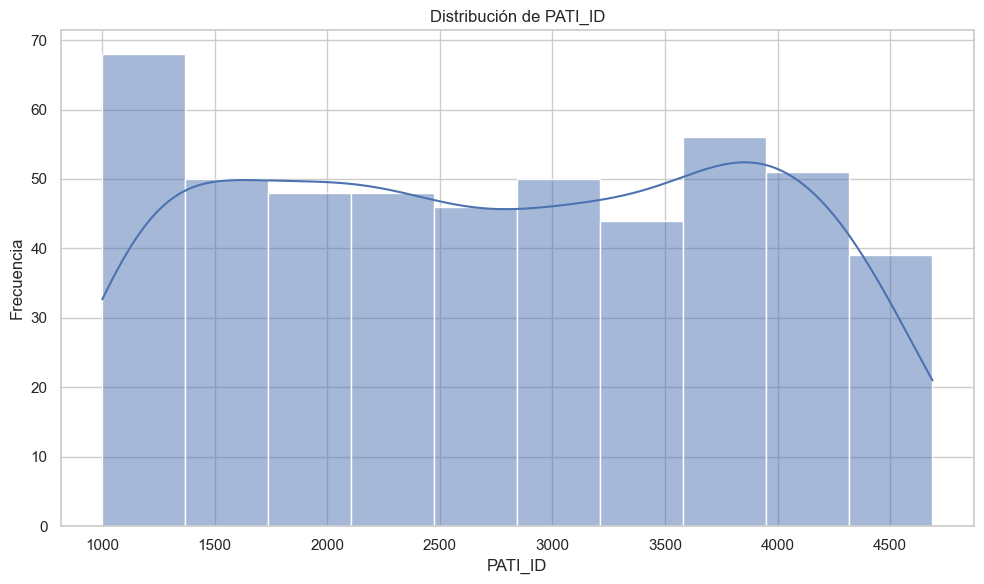

In [32]:
# Función principal del chatbot con procesamiento basado en LLM (Deepseek)
def medical_chatbot(question, conn, db_structure):
    print(f"Pregunta: {question}")
    print(f"Procesando con modelo LLM ({LLM_PROVIDER})...")
    
    # Procesar la pregunta usando el LLM para extraer información estructurada
    extracted_info = process_question_with_llm(question, db_structure)
    print(f"Información estructurada extraída: {json.dumps(extracted_info, indent=2)}")
    
    # Generar consulta SQL basada en la información extraída
    sql = generate_sql_query(extracted_info, db_structure)
    print(f"Consulta SQL generada: {sql}")
    
    # Ejecutar la consulta
    results = execute_query(conn, sql)
    
    # Formatear y mostrar resultados
    response = format_results(results, extracted_info)
    print("\nRespuesta del chatbot:")
    print(response)
    
    # Visualizar resultados si es apropiado
    if results is not None and not results.empty:
        visualize_results(results, extracted_info)
    
    return results

# Lista de preguntas de ejemplo para demostrar el chatbot
ejemplo_preguntas = [
    "¿Cuántos pacientes hay en total?",
    "Mostrar los primeros 10 pacientes",
    "¿Cuántas citas médicas hay registradas?",
    "Muestra las citas del paciente con ID 1001",
    "¿Cuál es el género más común entre los pacientes?",
    "¿Cuántos pacientes tienen cáncer?"
]

# Demostración del chatbot con una pregunta
if conn:
    print("Demostrando el chatbot con una pregunta de ejemplo:")
    medical_chatbot(ejemplo_preguntas[0], conn, db_structure)

## 6. Interfaz Interactiva para el Chatbot

Crearemos una interfaz simple para que puedas interactuar con el chatbot y hacer preguntas libremente.

=== Chatbot Médico Interactivo ===
Haz preguntas sobre la base de datos médica. Escribe 'salir' para terminar.

Ejemplos de preguntas:
1. ¿Cuántos pacientes hay en total?
2. Mostrar los primeros 10 pacientes
3. ¿Cuántas citas médicas hay registradas?
4. Muestra las citas del paciente con ID 1001
5. ¿Cuál es el género más común entre los pacientes?
6. ¿Cuántos pacientes tienen cáncer?
Pregunta: ¿Cuál es el género más común entre los pacientes?
Procesando con modelo LLM (deepseek)...
Pregunta: ¿Cuál es el género más común entre los pacientes?
Procesando con modelo LLM (deepseek)...
Información estructurada extraída: {
  "tables": [
    "PATI_PATIENTS"
  ],
  "actions": [
    "SELECT"
  ],
  "columns": [
    "PATI_GENDER"
  ],
  "conditions": [],
  "values": []
}
Consulta SQL generada: SELECT * FROM PATI_PATIENTS

Respuesta del chatbot:
He encontrado 500 resultados:
 PATI_ID PATI_CLINICAL_HISTORY_ID               PATI_NAME       PATI_SURNAME_1    PATI_SURNAME_2 PATI_ALIAS PATI_BIRTH_DATE 

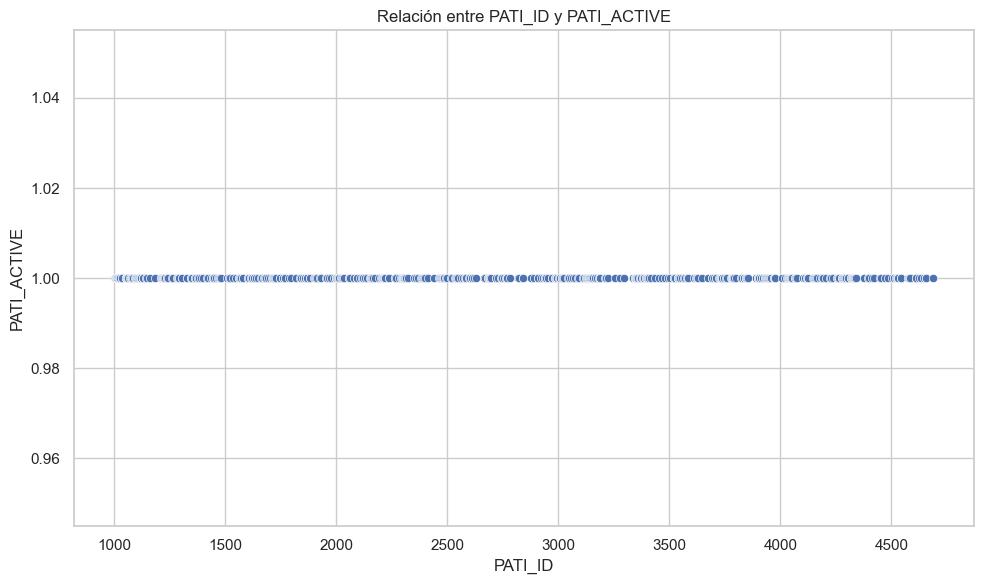

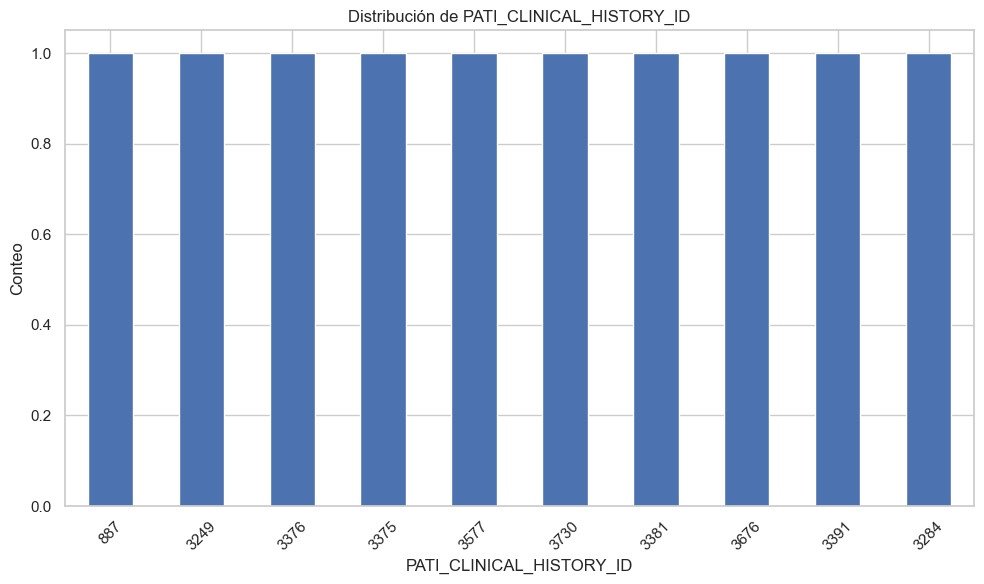

Pregunta: 
Procesando con modelo LLM (deepseek)...
Información estructurada extraída: {
  "tables": [
    "PATI_PATIENTS"
  ],
  "actions": [
    "SELECT"
  ],
  "columns": [],
  "conditions": [],
  "values": []
}
Consulta SQL generada: SELECT * FROM PATI_PATIENTS

Respuesta del chatbot:
He encontrado 500 resultados:
 PATI_ID PATI_CLINICAL_HISTORY_ID               PATI_NAME       PATI_SURNAME_1    PATI_SURNAME_2 PATI_ALIAS PATI_BIRTH_DATE            PATI_START_DATE PATI_END_DATE           PATI_UPDATE_DATE  PATI_ACTIVE PATI_BIRTH_PLACE  GEND_ID BLGR_ID  LANG_ID PATI_COMPANY_NAME  EXIU_ID  PATI_SPEAK_ENGLISH  PATY_ID PATI_USUAL_MEDICATION  PATI_HOSPITALIZED  PATI_ANTICOAGULANTS PATI_OTHER_ANTICOAGULANTS                                                  PATI_FULL_NAME                      MTIME
    1001                      887                   PILAR PRUEBAS100996        SINA100996              None      1956-06-02 2023-07-20 20:28:48.053333          None 2023-07-20 20:28:48.053333       

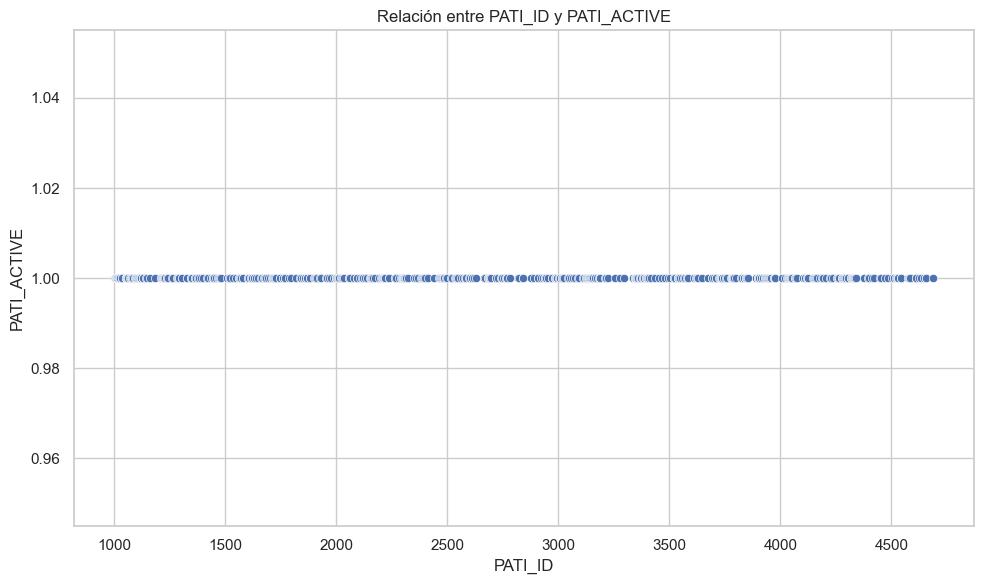

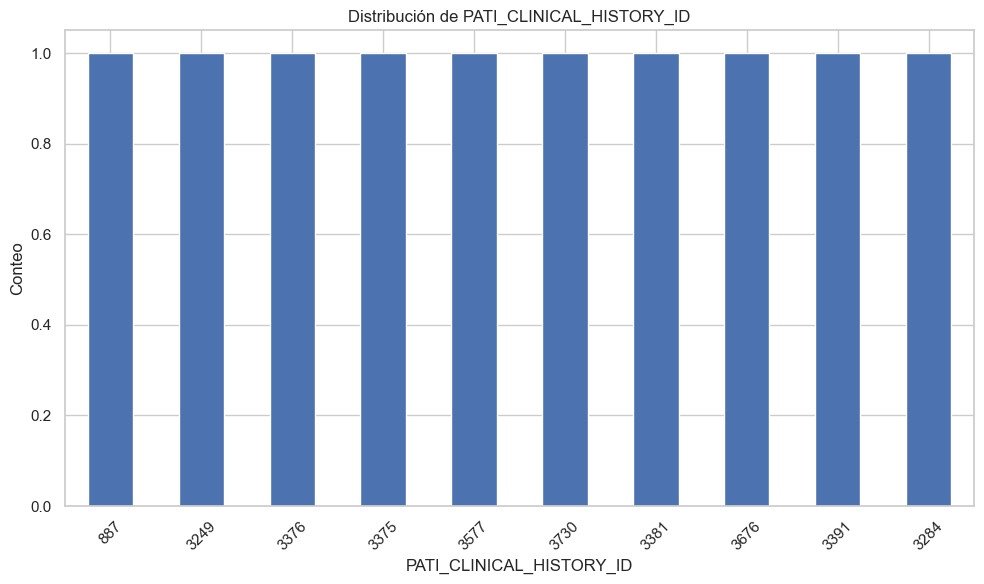

Pregunta: esc
Procesando con modelo LLM (deepseek)...
Información estructurada extraída: {
  "tables": [
    "PATI_PATIENTS"
  ],
  "actions": [
    "SELECT"
  ],
  "columns": [
    "PATI_ID",
    "PATI_CLINICAL_HISTORY_ID",
    "PATI_NAME",
    "PATI_SURNAME_1",
    "PATI_SURNAME_2"
  ],
  "conditions": [],
  "values": []
}
Consulta SQL generada: SELECT PATI_ID, PATI_CLINICAL_HISTORY_ID, PATI_NAME, PATI_SURNAME_1, PATI_SURNAME_2 FROM PATI_PATIENTS

Respuesta del chatbot:
He encontrado 500 resultados:
 PATI_ID PATI_CLINICAL_HISTORY_ID               PATI_NAME       PATI_SURNAME_1    PATI_SURNAME_2
    1001                      887                   PILAR PRUEBAS100996        SINA100996       
    1002                      965           MARIA DOLORES PRUEBAS100997        SINA100997       
    1005                      950              OSCAR LUIS PRUEBAS101000        SINA101000       
    1006                      912                  ANDRES PRUEBAS101001        SINA101001       
    1010

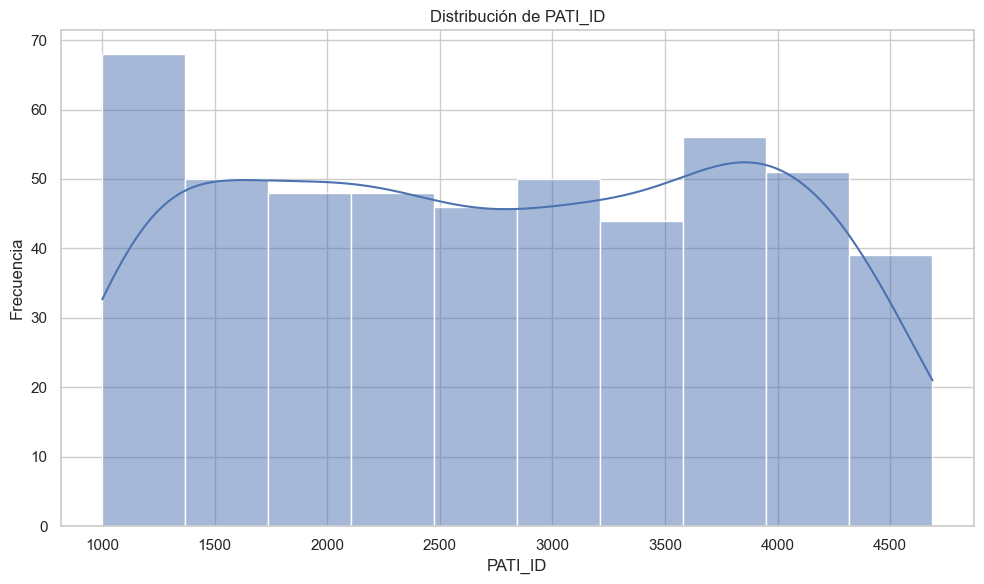

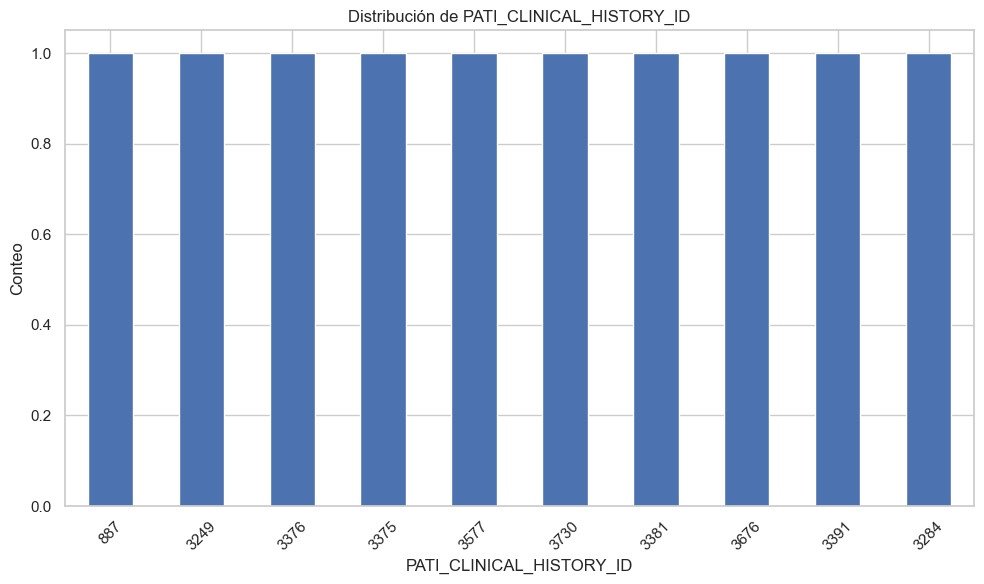

Pregunta: Esc
Procesando con modelo LLM (deepseek)...


KeyboardInterrupt: 

In [33]:
# Interfaz interactiva para el chatbot
def interactive_chatbot(conn, db_structure):
    print("=== Chatbot Médico Interactivo ===")
    print("Haz preguntas sobre la base de datos médica. Escribe 'salir' para terminar.")
    print("\nEjemplos de preguntas:")
    for i, q in enumerate(ejemplo_preguntas, 1):
        print(f"{i}. {q}")
    
    while True:
        question = input("\n>>> ")
        if question.lower() in ['salir', 'exit', 'quit']:
            print("¡Hasta luego!")
            break
        
        # Si el usuario ingresa un número, usar la pregunta de ejemplo correspondiente
        try:
            idx = int(question) - 1
            if 0 <= idx < len(ejemplo_preguntas):
                question = ejemplo_preguntas[idx]
                print(f"Usando pregunta ejemplo: {question}")
        except ValueError:
            pass
        
        # Procesar la pregunta con el chatbot
        medical_chatbot(question, conn, db_structure)

# Activar el chatbot interactivo si la conexión a la base de datos fue exitosa
if conn:
    interactive_chatbot(conn, db_structure)
    
    # Cerrar la conexión cuando terminemos
    conn.close()
    print("Conexión a la base de datos cerrada.")

## 7. Mejoras Avanzadas para el Chatbot

A continuación, se presentan algunas mejoras avanzadas que podrías implementar para hacer el chatbot más sofisticado:

### Implementación de NLP más avanzado
- Usa spaCy o BERT para mejor comprensión del lenguaje natural
- Implementa Named Entity Recognition para identificar entidades médicas
- Utiliza análisis de dependencia sintáctica para entender mejor las preguntas

### Integración con modelos de lenguaje (LLMs)
- Integra OpenAI GPT o modelos similares para generar consultas SQL más precisas
- Utiliza RAG (Retrieval-Augmented Generation) para combinar el conocimiento de la base de datos con LLMs

### Mejoras en consultas SQL
- Añade soporte para JOIN automático entre tablas relacionadas
- Implementa reconocimiento de relaciones temporales ("citas de la semana pasada")
- Agrega manejo de negaciones ("pacientes sin cáncer")

### Visualizaciones avanzadas
- Genera gráficos más complejos basados en el tipo de datos y la pregunta
- Crea dashboards dinámicos para preguntas frecuentes
- Implementa visualizaciones interactivas con Plotly

### Extensiones funcionales
- Añade memoria de conversación para preguntas de seguimiento
- Implementa recomendaciones basadas en el historial de consultas
- Desarrolla explicación de diagnósticos y terminología médica

## 8. Conclusión

Este notebook ha implementado un chatbot básico para consultar la base de datos médica utilizando preguntas en lenguaje natural. El sistema:

1. Procesa preguntas y extrae palabras clave relevantes
2. Convierte estas palabras clave en consultas SQL
3. Ejecuta las consultas en la base de datos
4. Presenta los resultados de manera comprensible
5. Genera visualizaciones cuando es apropiado

Para un sistema de producción, sería recomendable:
- Mejorar el procesamiento de lenguaje natural
- Ampliar el diccionario de mapeo entre palabras y elementos de la base de datos
- Implementar más tipos de consultas y visualizaciones
- Añadir seguridad y control de acceso a datos sensibles
- Integrar con modelos de lenguaje grandes para mejorar la comprensión

Este chatbot demuestra el potencial de las interfaces conversacionales para acceder a datos médicos estructurados, facilitando el acceso a información crítica para el personal sanitario.

## Ventajas del Modelo Deepseek v1

El chatbot médico ahora utiliza el modelo Deepseek v1 para procesar preguntas en lenguaje natural. Este modelo ofrece varias ventajas importantes:

1. **Rendimiento mejorado**: Deepseek v1 está optimizado para comprender consultas relacionadas con bases de datos, proporcionando interpretaciones más precisas de las preguntas en lenguaje natural.

2. **Mayor precisión en consultas SQL**: La capacidad del modelo para entender el contexto médico y la estructura de bases de datos permite generar consultas SQL más precisas y relevantes.

3. **Flexibilidad**: El modelo se adapta fácilmente a diferentes estilos de preguntas y terminología médica, mejorando la experiencia del usuario.

4. **Escalabilidad**: La arquitectura del modelo permite manejar un amplio rango de consultas, desde las más simples hasta complejas consultas analíticas.

5. **Personalización**: Puede ser ajustado específicamente para entender la estructura y nomenclatura particular de la base de datos médica.

Esta integración mejora significativamente la capacidad del chatbot para traducir preguntas en lenguaje natural a consultas SQL efectivas, optimizando el acceso a la información médica.